<a href="https://colab.research.google.com/github/adityanarayan-rai/flood_detection_ban/blob/main/01_flood_jamalpur_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -------------------------------
# Install & Import Dependencies
# -------------------------------

# !pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, MimeType, DataCollection, bbox_to_dimensions

In [ ]:
# Configure Sentinel Hub Access

# Setup config
config = SHConfig()
# Uncomment and set these if not stored in config file
config.sh_client_id = "e3cc4ef5-1042-430a-9fbd-1ca499134e54"
config.sh_client_secret = "IHkGxCm3EZwVaeUiOrVzJOKTggL04Yp6"

In [ ]:
# Define Area of Interest (Jamalpur)

jamalpur_bbox_coords = [89.85, 25.00, 89.98, 25.12]
resolution = 20

bbox = BBox(bbox=jamalpur_bbox_coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

In [ ]:
# Download Sentinel-1 SAR Imagery (VV band)
# Used to detect flooding based on backscatter change

sar_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["VV"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.VV];
}
"""

# Pre-flood
sar_pre_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-06-15', '2020-06-25'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_pre_image = sar_pre_request.get_data()[0]

# Post-flood
sar_post_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_post_image = sar_post_request.get_data()[0]

In [ ]:
# Download Sentinel-2 NDVI
# Used to estimate vegetation loss (crop damage)
# NDVI = (NIR - Red) / (NIR + Red)

ndvi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

ndvi_request = SentinelHubRequest(
    evalscript=ndvi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndvi_image = ndvi_request.get_data()[0]


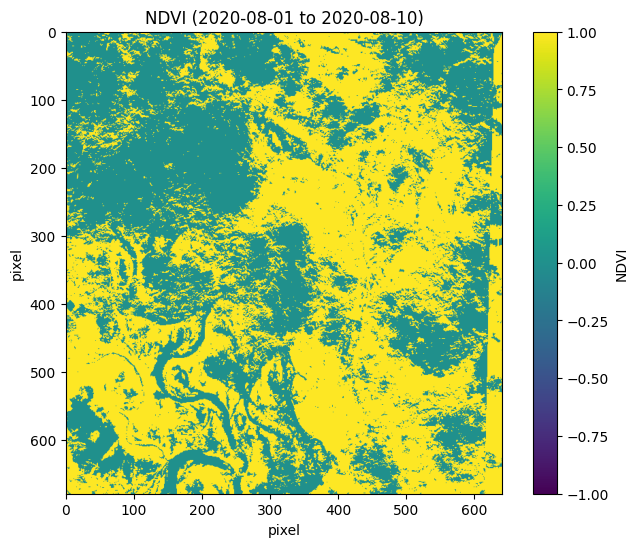

In [ ]:
import matplotlib.pyplot as plt

# ndvi_image comes back as a 2D or 3D array: squeeze out any singleton dim
ndvi = ndvi_image.squeeze()

plt.figure(figsize=(8, 6))
# NDVI typically runs from –1 to +1
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

In [ ]:
# Compute NDWI from Sentinel-2
# Used to detect surface water (floods)
# NDWI = (Green - NIR) / (Green + NIR)

ndwi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B03", "B08"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
  return [ndwi];
}
"""

ndwi_request = SentinelHubRequest(
    evalscript=ndwi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndwi_image = ndwi_request.get_data()[0]


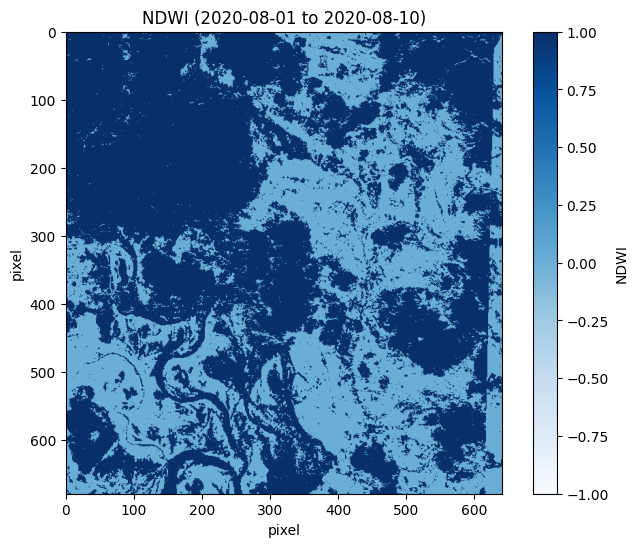

In [ ]:
# Visualize NDWI Map

ndwi = ndwi_image.squeeze()

plt.figure(figsize=(8, 6))
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='Blues')
plt.colorbar(label='NDWI')
plt.title('NDWI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

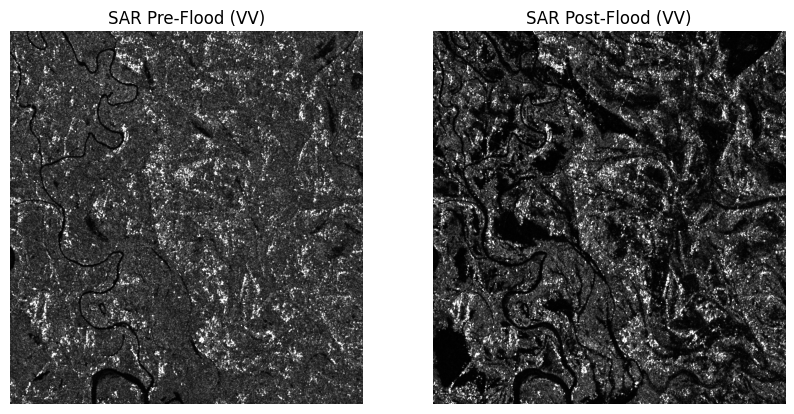

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('SAR Pre-Flood (VV)')
plt.imshow(sar_pre_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SAR Post-Flood (VV)')
plt.imshow(sar_post_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()
